# Looking at CanESM output and diagnostics
## CanESM walkthrough 
Neil Swart, CCCma, April 2024

In [1]:
# Use this to convert this notebook to slides
#jupyter nbconvert 'canesm_output_tutorial.ipynb' --to slides --post serve

---

## Introduction

- The goal of this notebook & lesson is to help users to get started with looking at model output from CanESM.
- We will look at:
   - pre-computed one dimensional Runtime Diagnostics (RTD) via an online RTD browser 
   - Full domain model data via CMIP6 style NetCDF output

- This notebook will use python and xarray to present examples, but the concepts transfer to any analysis package.

- This notebook and associated material can be cloned from the CP4C repository at: https://gitlab.com/CP4C/cp4c-docs.git

---

## Key learning objectives

1. Use the Runtime Diagnostics (RTD) browser to quickly view 1d fields, verify against existing reference simulations, and as a basis for checking your own diagnostics.

2. Learn to parse for data through the cmorized CMIP6 data tree, and to make use of metadata

3. Become aware of the different grids in the atmosphere and ocean, weighting calculations, and remapping when necessary

---

## Model diagnostic pipeline

- In parallel with the model, an extensive diagnostics job post-processes the raw model output into usable formats
- We will only focus on the runtime diagnostics (RTD) and final cmorized NetCDF files

![canesm-diagnostics-pipeline](./canesm-diagnostics-pipeline.png)


---

## Runtime diagnostics

- One dimensional diagnostics (global/regional means) are computed for hundreds of variables every model year and placed in files
- A dynamic online website can be used to view the RTD files, and compare runs 
- [CP4C wiki](https://gitlab.com/CP4C/cp4c-docs/-/wikis/home) contains a link to the CP4C RTD browser, and lists of reference runs

---

### CMIP6-style cmorized NetCDF

- The CMIP6 exercise defined a comprehensive data request, naming convention, and CF / metadata standards
- Cmorization is the process of converting data to this standard, and is done for Niagara runs
- This data structure and format should be familiar to many users, and is highly inter-operable
- The cmorized data goes into a directory under `output/<year>/nc_output/CMIP6/`
-  More information about the CMIP6 data request and e.g. variable names can be found on the [cmip6dr homepage](https://cmip6dr.github.io/Data_Request_Home/)

---

## The CMIP data tree to table level
The directory structure appears as below, where the levels below CMIP6 indicate, `project`, `organization`, `source_id` (model name), `experiment_id` (experiment name), `member_id` (aka realization) and `table_id` (realm and frequency). Each of these terms has a clear definition in the CMIP nomenclature. 

```
nc_output/CMIP6/
└── CMIP
    └── CP4C
        └── CanESM5-1
            └── piControl
                └── r1i1p1f1
                    ├── 3hr
                    ├── 6hrPlevPt
                    ├── AERday
                    ├── AERmon
                    ├── AERmonZ
                    ├── Amon
                    ├── CF3hr
                    ├── CFday
                    ├── CFmon
                    ├── day
                    ├── E3hr
                    ├── Eday
                    ├── EdayZ
                    ├── Emon
                    ├── EmonZ
                    ├── fx
                    ├── LImon
                    ├── Lmon
                    ├── Oclim
                    ├── Omon
                    ├── Oyr
                    ├── SIday
                    └── SImon

```

---

## CMIP data tree at the table level

Beneath each table, will be a series of directories, one per variable, and the netcdf files occur a few levels below that. For example, under the `Omon`, the structure appear as:

```
Omon/
├── agessc
│   └── gn
│       └── v20190429
│           └── agessc_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601001-601012.nc
├── chl
│   └── gn
│       └── v20190429
│           └── chl_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601001-601012.nc
```

- the top level is for the variable name (`agessc`=ideal age and `chl` is ocean chlorophyll concentration), 
- `gn` means "grid native", and below that there is a directory for the version <`20190409`> (generall not important). 
- Below that is a netcdf file, with the data and metadata. 

---

In [1]:
# This is Neil's basic python analysis environment to look at files.
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import cftime
import dask
import numpy as np
import os
import nc_time_axis
import sys

## Example 1: Surface air temperature 

Data will be loaded from a previous run on disk. Change paths according to your own runs.

Note:

- In CMIP6, the surface air temperature variable is called `tas`, and we will look at monthly mean values, from the `Amon` table.
- You can use `ncdump -h` to examine the metadata for a `tas` file via the bash shell i.e.

``` bash
    ncdump -h tas_Amon_CanESM5-1_piControl_r1i1p1f1_gn_601001-601012.nc
```

- We will examine metadata in python below.

In [4]:
# Data from Neil's test run. Change the paths for your runs.
# NB: the name of this test run "nia-his-51-p1-imsi-02" is confusing. It is actually a piControl run. 
base_path = "/home/n/nswart/nswart/scratch/nia-his-51-p1-imsi-02/output/{year}/nc_output/CMIP6/CMIP/CP4C/CanESM5-1/piControl/r1i1p1f1/"

# Note using `mfdataset` with * operators, so that xarray will auto-concatenate data across years.
ds_tas = xr.open_mfdataset(os.path.join(base_path.format(year='*'), 'Amon/tas/gn/v20190429/','tas_*.nc'))

---

In [5]:
# Global attributes of the file 
ds_tas.attrs

{'CCCma_model_hash': 'Unknown',
 'CCCma_parent_runid': 'v510-pict',
 'CCCma_pycmor_hash': 'not applicable',
 'CCCma_runid': 'nia-his-51-p1-imsi-02',
 'Conventions': 'CF-1.7 CMIP-6.2',
 'DISCLAIMER': 'PRELIMINARY DATA - NOT FOR PUBLICATION.',
 'YMDH_branch_time_in_child': '6000:01:01:00',
 'YMDH_branch_time_in_parent': '6000:01:01:00',
 'activity_id': 'CMIP',
 'branch_method': 'Spin-up documentation',
 'branch_time_in_child': 1514750.0,
 'branch_time_in_parent': 1514750.0,
 'contact': 'contact.cp4c@gmail.com',
 'creation_date': '2024-04-12T22:55:11Z',
 'data_specs_version': '01.00.33',
 'experiment': 'pre-industrial control',
 'experiment_id': 'piControl',
 'external_variables': 'areacella',
 'forcing_index': 1,
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.CP4C.CanESM5-1.piControl.none.r1i1p1f1',
 'grid': 'T63L49 native atmosphere, T63 Linear Gaussian Grid; 128 x 64 longitude/latitude; 49 levels; top level 1 hPa',
 'grid_label': 'gn',
 'history': '2024

In [6]:
# Variable specific metadata
ds_tas.tas

<xarray.DataArray 'tas' (time: 132, lat: 64, lon: 128)>
dask.array<concatenate, shape=(132, 64, 128), dtype=float32, chunksize=(12, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 6000-01-16 12:00:00 ... 6010-12-16 12:00:00
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    units:          K
    original_name:  ST
    history:        degctok 2024-04-12T22:55:11Z altered by CMOR: Treated sca...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

- This shows us we have a file with lat/lon dimensions 64x128
- This is the T63 gaussian grid from the atmosphere
- We are also loading 132 months = 11 years of data
- The global attributes contain significant additional information about the run provenance and model details

---

## Basic map of surface air temperature

- Plot a map of tas for the first month in the dataset

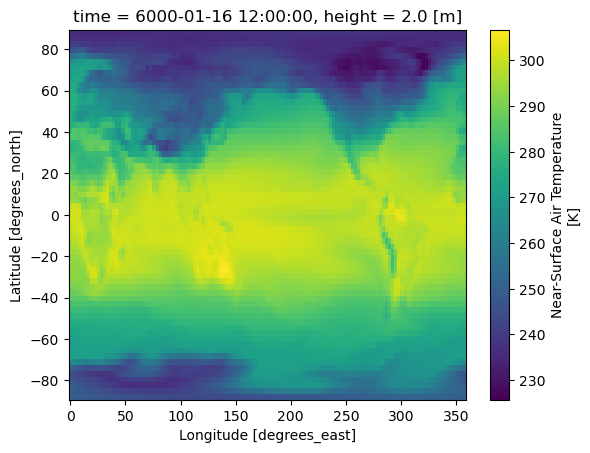

In [27]:
ds_tas.isel(time=0).tas.plot()

---

### Computing and verifying global mean surface air temperature

4.022088623046898

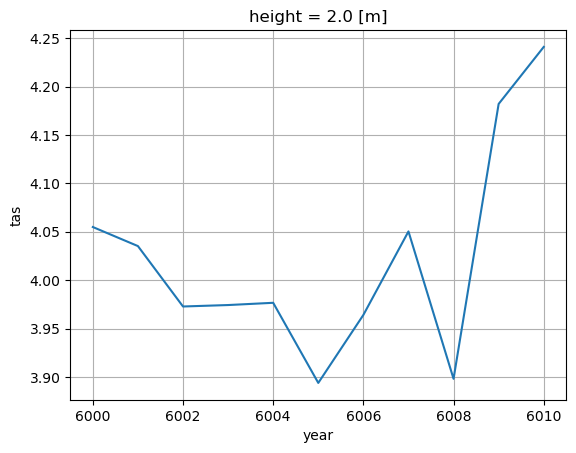

In [4]:
tas_gm = ds_tas.mean(dim=['lon', 'lat'])                          # compute a global mean
(tas_gm.tas.groupby('time.year').mean(dim='time') -273.15).plot() # annual mean and convert K to C
plt.grid()
tas_gm.tas.mean(dim='time').values -273.15                        # print the time average

---

## Checking vs RTD

- The above result gives a global mean temperature of 4C. Is it correct? 
- A good way to validate what you are doing is to compare against the RTD where possible. In this case, if we look at the RTD of GMST for the same run, we see the average temperature is more like 13.3C, and the pattern is different: 

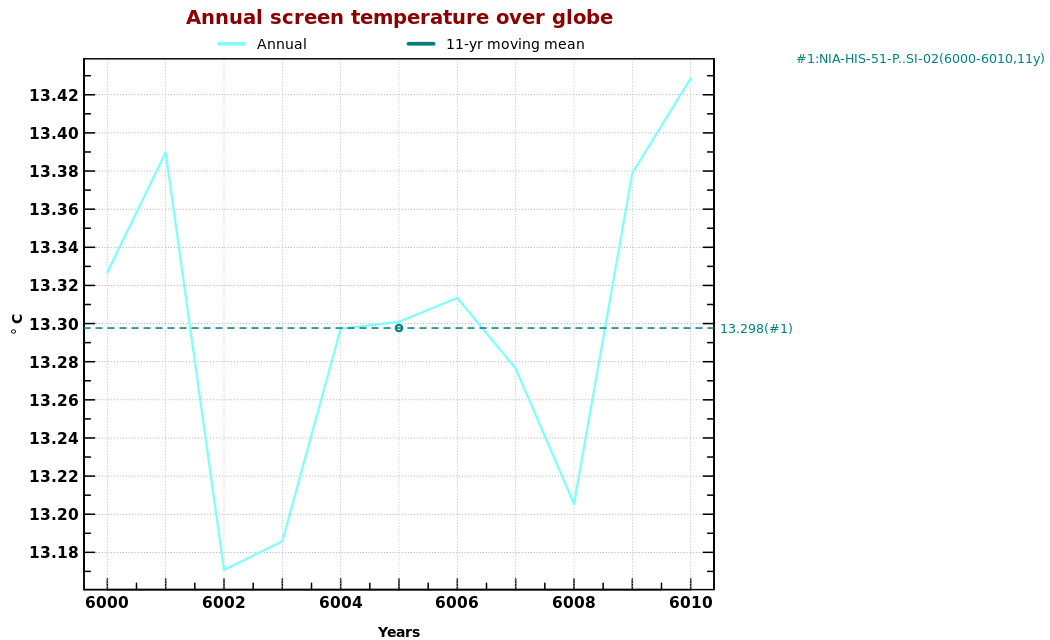

---

## Fixing the global mean computation

- The computation above was done incorrectly on purpose to illustrate the utility of cross-checking against known references like the RTD. 
- The mistake was computing a straight average, without using area weighting. 
- We can easily fix that by using the amtmospheric grid cell areas included with the data, under a variable called `areacella`.

---

13.296990966796898

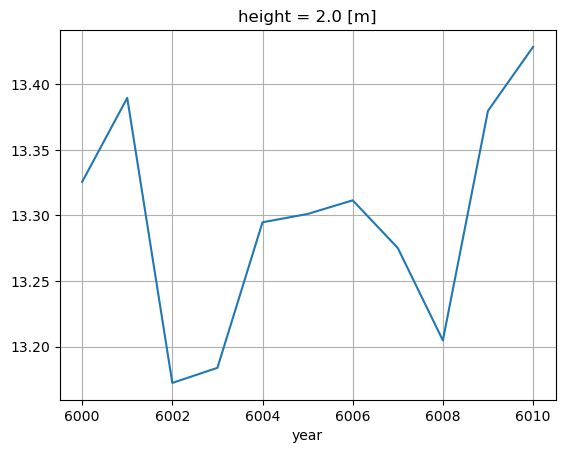

In [5]:
ds_areacella = xr.open_dataset('/home/n/nswart/nswart/scratch/nia-his-51-p1-imsi-02/output/6000/nc_output/CMIP6/CMIP/CP4C/CanESM5-1/piControl/r1i1p1f1/fx/areacella/gn/v20190429/areacella_fx_CanESM5-1_piControl_r1i1p1f1_gn.nc')
global_area = ds_areacella.areacella.sum(dim=['lon', 'lat'])                         # Global area
tas_gm = (ds_areacella.areacella * ds_tas.tas).sum(dim=['lon', 'lat']) / global_area # Properly area weighted mean of tas
(tas_gm.groupby('time.year').mean(dim='time') -273.15).plot()                        # Plot the annual mean global mean
plt.grid()
tas_gm.mean(dim='time').values -273.15                                               # print the average value

---

## Example 2: Ocean potential temperature


- CanESM5 / NEMO ocean data is on the ORCA1 tripolar grid tripolar grid.
-  Remapping to a standard grid is often helpful.
- In CMIP6, ocean potential temperature is named `thetao`, and we will look at the monthly means from the Omon table

In [6]:
ds_thetao = xr.open_mfdataset(os.path.join(base_path.format(year='*'), 'Omon/thetao/gn/v20190429/','thetao_*.nc'))

In [31]:
ds_thetao.thetao

<xarray.DataArray 'thetao' (time: 132, lev: 45, j: 291, i: 360)>
dask.array<concatenate, shape=(132, 45, 291, 360), dtype=float32, chunksize=(12, 45, 291, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 6000-01-16 12:00:00 ... 6010-12-16 12:00:00
  * lev        (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        Diagnostic should be contributed even for models using co...
    units:          degC
    original_name:  votemper
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello

---

## Plot a map of ocean temperatres at 1000 m

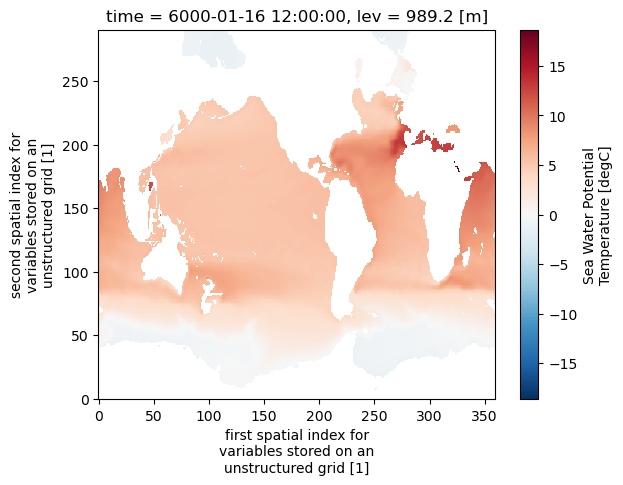

In [7]:
ds_thetao.sel(lev=1000, method='nearest').isel(time=0).thetao.plot()

While temperatures look reasonable, your can see the tripolar grid gives a strange continental layout. We will deal with that below by remapping. 

---

#### Regridding to a standard grid

Below we will remap to a standard grid, then do the same plot of temperature at 1000 m.

In [9]:
def regrid_1x1(ds):
    """Bilinear remap dataset to a global 1x1 grid using xESMF"""
    ds_out = xe.util.grid_global(1, 1,cf=True)
    regridder = xe.Regridder(ds, ds_out, "bilinear", periodic=True)
    ds_rm = regridder(ds)
    return ds_rm

In [10]:
ds_thetao_rm = regrid_1x1(ds_thetao)

---

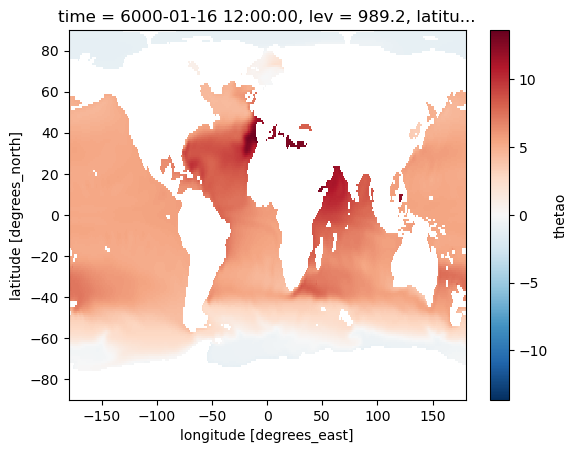

In [11]:
ds_thetao_rm.sel(lev=1000, method='nearest').isel(time=0).thetao.plot()

We can see in the above, we now have more regular axes of latitude and longitude, rather than the cell indices of the tripolar grid. 

---

## Zonal mean ocean section 
With the remapped data, we can also sensibly do things like take the zonal mean:

(5500.0, 0.0)

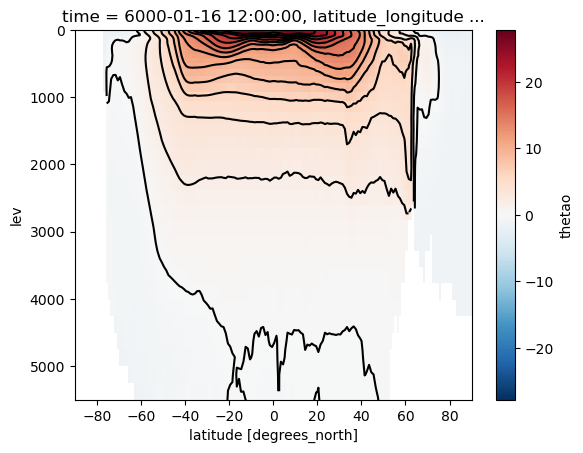

In [19]:
ds_thetao_rm.isel(time=0).mean(dim='lon').thetao.plot()
ds_thetao_rm.isel(time=0).mean(dim='lon').thetao.plot.contour(colors=['k'], levels=np.arange(-2,26,2))
plt.gca().set_ylim([5500,0])

---

## Example 3: Land carbon flux

- Note land data is also on the 128x64 T63 atmospheric gaussian grid

In [32]:
ds_npp = xr.open_mfdataset(os.path.join(base_path.format(year='*'), 'Lmon/npp/gn/v20190429/','npp*.nc'))

In [33]:
ds_npp.npp

<xarray.DataArray 'npp' (time: 132, lat: 64, lon: 128)>
dask.array<concatenate, shape=(132, 64, 128), dtype=float32, chunksize=(12, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 6000-01-16 12:00:00 ... 6010-12-16 12:00:00
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    standard_name:  net_primary_productivity_of_biomass_expressed_as_carbon
    long_name:      Net Primary Production on Land as Carbon Mass Flux [kgC m...
    comment:        up is changed to down! CFNP*12.011E-9, CMIP_table_comment...
    units:          kg m-2 s-1
    original_name:  CFNP
    history:        mltby12em9 2024-04-12T23:06:55Z altered by CMOR: Reordere...
    cell_methods:   area: mean where land time: mean
    cell_measures:  area: areacella

---

 - There are only valid values over land, as expected.

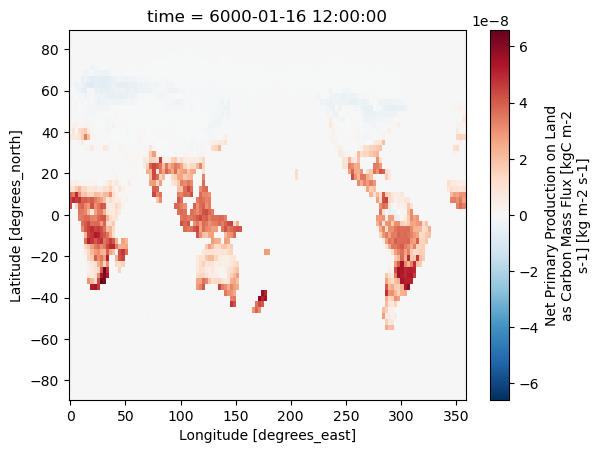

In [34]:
ds_npp.npp.isel(time=0).plot()